# Twenty Years of `rho.org.uk` — Statistics

This notebook scans the files in a [Jekyll](https://jekyllrb.com) `_posts` directory, calculates statistics for them, and produces a visualisation of the posts over time. It was created in support of [this post](http://rob.rho.org.uk/2022/01/twentyyears.md). I won't claim it as an example of great style, either Python generally, or Pandas and Matplotlib specifically, but it may be a useful starting point if you're looking to do something similar.

In [1]:
from pathlib import Path
from dataclasses import dataclass
import re

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# The only dependency 
import pandas as pd

matplotlib.rcParams["figure.figsize"] = (21,7)

In [2]:
@dataclass(init=False)
class Post:
    "A dataclass to represent an individual post"
    name: str
    year: int
    month: int
    day: int
    postlength: int

    # Regular expression to match Jekyll-style post filenames
    path_re = re.compile(r'(?P<year>\d{4})-(?P<month>\d{1,2})-(?P<day>\d{1,2})-(?P<name>.*)')

    def __init__(self, path: Path):
        "Initialise a post based on a file path"
        assert (m := Post.path_re.match(path.stem)), path
        self.name = m["name"]
        self.year = int(m["year"])
        self.month = int(m["month"])
        self.day = int(m["day"])

        # Read the content of the post, strip out things that look like HTML or Markdown
        # tags and perform a word count on the remainder
        text = path.read_text()
        self.postlength = sum(1 for x in re.finditer(r'\w+', re.sub(r"""(?xsm)
              <[^>]*>              # HTML tags
            | \A---.*^---          # YAML metadata
            | !\[[^]]*\]\([^)]*\)  # Markdown images 
            | \[\^[^]]*\]          # Markdown footnote tags
            | \]\([^)]*\)          # Markdown link targets
        """, ' ', text)))

In [3]:
# Load all posts
def recursive_files(path):
    "Yield all files transitively under a path, depth-first"
    for f in path.iterdir():
        if f.is_dir():
            yield from recursive_files(f)
        else:
            yield f

# Find the _posts directory relative to this notebook; adjust to suit your layout
posts_dir = Path.cwd().parent.parent / "_posts"

posts = pd.DataFrame([Post(p).__dict__ for p in recursive_files(posts_dir)])
posts = posts[posts.year < 2022]

In [4]:
posts.postlength.describe()

count     221.000000
mean      259.647059
std       407.960384
min         4.000000
25%        57.000000
50%       123.000000
75%       282.000000
max      4323.000000
Name: postlength, dtype: float64

In [5]:
posts[posts.postlength == 4]

name  year  month  day  postlength
129               oh_dear  2005      1    5           4
168  where_can_you_see_li  2004      5    9           4
184  venerable_educationa  2004     10    9           4

In [6]:
posts[posts.postlength == 4323]

name  year  month  day  postlength
40  tsconf2019_cutting_edge  2020      2   10        4323

In [11]:
# Summary by year
posts.groupby("year").name.count()

year
2002    38
2003    40
2004    23
2005    19
2006     4
2007     1
2008    12
2009     9
2010     9
2011     9
2012     9
2013     6
2014     7
2015    10
2016     4
2017     5
2018     1
2019     4
2020     5
2021     6
Name: name, dtype: int64

In [8]:
# Add a column representing the date of a post as a month with a fractional part for the day
posts['monthday'] = posts.month + posts.day/31

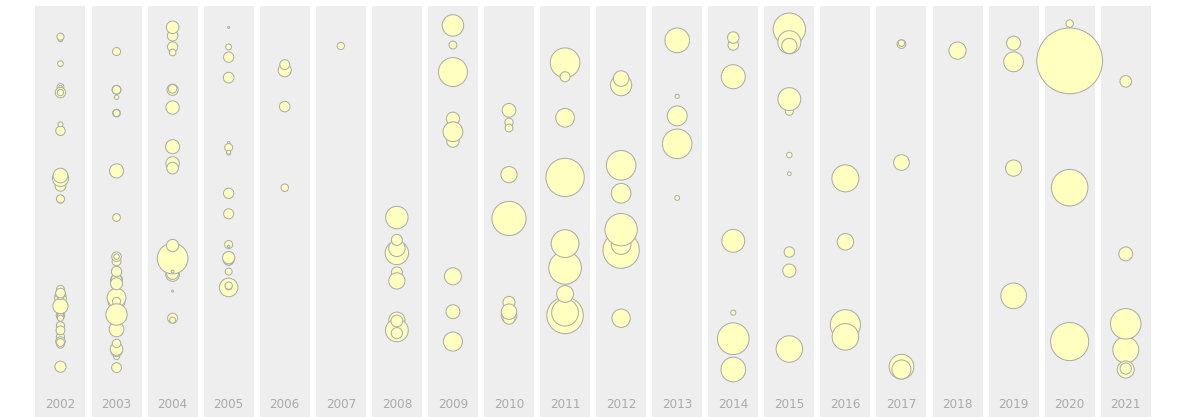

In [12]:
# Post length chart; the X axis is year, the Y access is point within the year,
# and the marker is scaled relative to the post length
posts.plot.scatter("year", "monthday",  s=posts.postlength, marker="o",
                   color="#ffffbf", edgecolors="#aaaaaa",
                   xticks=range(2002,2022))
ax = plt.gca()

# Use very wide vertical lines on the year ticks to provide the strips
plt.grid(axis="x", color="#eeeeee", linewidth=50)
ax.set_axisbelow(True)

# Match the width and colour of the strips for the labels at the bottom
plt.tick_params(axis='x', length=30, width=50, pad=-20, color="#eeeeee", labelcolor="#aaaaaa", labelsize="large")
plt.xlabel("")

# Hide the borders and the Y axis, and put January at the top
for s in ax.spines.values(): s.set_visible(False)
ax.yaxis.set_visible(False)
ax.invert_yaxis()

# Use a zero opacity background
ax.set_facecolor("#00000000")

plt.show()
